100%|██████████| 111390/111390 [07:04<00:00, 262.47it/s]


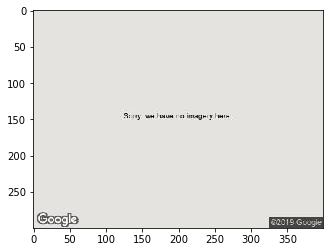

In [1]:
# 查看无效的 place pulse 图片列表
# 比如 514135dcfdc9f04926004b61
import cv2
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
image_dir = 'F:\\data\\PlacePulse\\images'
files = os.listdir(image_dir)
sample_image_file_name = os.path.join(image_dir, '514135dcfdc9f04926004b61.jpg')
sample_image = np.array(Image.open(sample_image_file_name))
plt.imshow(sample_image)
broken_list = []
half_broken_list = []
cnt = 0
for file in tqdm(files):
    try:
        cur_img = np.array(Image.open(os.path.join(image_dir, file)))
        if np.max(np.abs(cur_img - sample_image)) == 0:
            broken_list.append(file)
    except Exception:
        half_broken_list.append(file)
    cnt += 1

In [2]:
# 共 663 张无效图片，下面保存无效图片名称
all_broken_list = broken_list + half_broken_list
print(len(broken_list), len(half_broken_list), len(all_broken_list))
with open('F:\\data\\PlacePulse\\broken_image_list.txt', 'w') as f:
    for line in broken_list:
        f.write(line + '\n')

663 75 738


In [4]:
# 更新csv
import pandas as pd
src_csv_file = os.path.join("F:\\data\\PlacePulse\\votes.csv")
target_csv_file = os.path.join("F:\\data\\PlacePulse\\annos.csv")
broken_names = [name[:name.find('.')] for name in all_broken_list]
df = pd.read_csv(src_csv_file)
delete_line_ids = []
cur_line = 0
for r in df.iterrows():
    if r[1].left_id in broken_names or r[1].right_id in broken_names:
        delete_line_ids.append(cur_line)
    cur_line += 1
print('{} has {} error samples'.format(src_csv_file, len(delete_line_ids)))
df = df.drop(delete_line_ids)
df.to_csv(target_csv_file, index=False)

F:\data\PlacePulse\votes.csv has 15761 error samples


In [6]:
train_percent = 0.65
val_percent = 0.15
target_dir = "F:\\data\\PlacePulse"
base_file_name = '{}_{}_equal.csv'
for category in tqdm(['beautiful', 'boring', 'depressing', 'lively', 'safety', 'wealthy']):
    df = pd.read_csv(target_csv_file)
    df = df[df.category == category]
    not_equal_df = df[df.winner != 'equal']

    num_train = int(len(not_equal_df) * train_percent)
    num_val = int(len(not_equal_df) * val_percent)
    num_test = len(not_equal_df) - num_val - num_train

    not_equal_df = not_equal_df.sample(frac=1.0)  # shuffle
    train_df = not_equal_df[:num_train]
    val_df = not_equal_df[num_train:-num_test]
    test_df = not_equal_df[-num_test:]

    equal_df = df[df.winner == 'equal']
    train_df = pd.concat([train_df, equal_df])

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    target_format = os.path.join(target_dir, base_file_name)

    train_df.to_csv(target_format.format(category, 'train'), index=False)
    val_df.to_csv(target_format.format(category, 'val'), index=False)
    test_df.to_csv(target_format.format(category, 'test'), index=False)

100%|██████████| 6/6 [00:19<00:00,  3.19s/it]
